# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [7]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
anio = 2026
name_file = 'ecobici_hsbc' 
nombre_archivo = f'../data/data_forecast_{anio}/data_forecast_{anio}_silver/numero_membresia_{name_file}_limpio.csv'
print(f"Cargando el archivo: {nombre_archivo}")  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Cargando el archivo: ../data/data_forecast_2026/data_forecast_2026_silver/numero_membresia_ecobici_hsbc_limpio.csv
Rango de fechas: 2024-12-20 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
0,6,5694.0,2024-12-20,6.0
1,3,2847.0,2024-12-21,3.0
2,5,4745.0,2024-12-22,5.0
3,1,949.0,2024-12-23,1.0
4,1,949.0,2024-12-24,1.0


In [8]:
df_main.describe()

,cantidad_Vendida,ingresos_totales_reales,fecha,cantidad_Vendida_imputado
count,323.000000,323.000000,323,323.000000
mean,8.978328,8139.763034,2025-06-21 10:19:41.424148480,8.730650
min,1.000000,949.000000,2024-12-20 00:00:00,1.000000
25%,6.000000,5551.640000,2025-04-02 12:00:00,6.000000
50%,9.000000,7686.840000,2025-06-22 00:00:00,9.000000
75%,11.000000,10083.100000,2025-09-10 12:00:00,11.000000
max,21.000000,19501.920000,2025-11-30 00:00:00,18.000000
std,3.893317,3535.380550,NaN,3.498698


Filtro para obtener muestra de datos

In [9]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'cantidad_Vendida_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [10]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """
df['cap'] = 20

# 2. Configurar el modelo con crecimiento logístico
m = Prophet(
            changepoint_prior_scale=0.05,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
            seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
            daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
            #########
            growth='logistic', 
            seasonality_mode='multiplicative',
            yearly_seasonality=True)

m.add_country_holidays(country_name='MX')
m.fit(df)


17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:13 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [11]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365)
future['cap'] = 20

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

            ds  cap
683 2026-11-26   20
684 2026-11-27   20
685 2026-11-28   20
686 2026-11-29   20
687 2026-11-30   20


Paso 5: Realizar la Predicción (Forecast)

In [12]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds       yhat  yhat_lower  yhat_upper
683 2026-11-26   7.979301    4.228488   11.880174
684 2026-11-27  10.886913    7.177893   14.627574
685 2026-11-28  11.584364    7.899199   15.176686
686 2026-11-29  18.326107   14.468085   22.185263
687 2026-11-30  12.466813    8.892199   16.042506


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

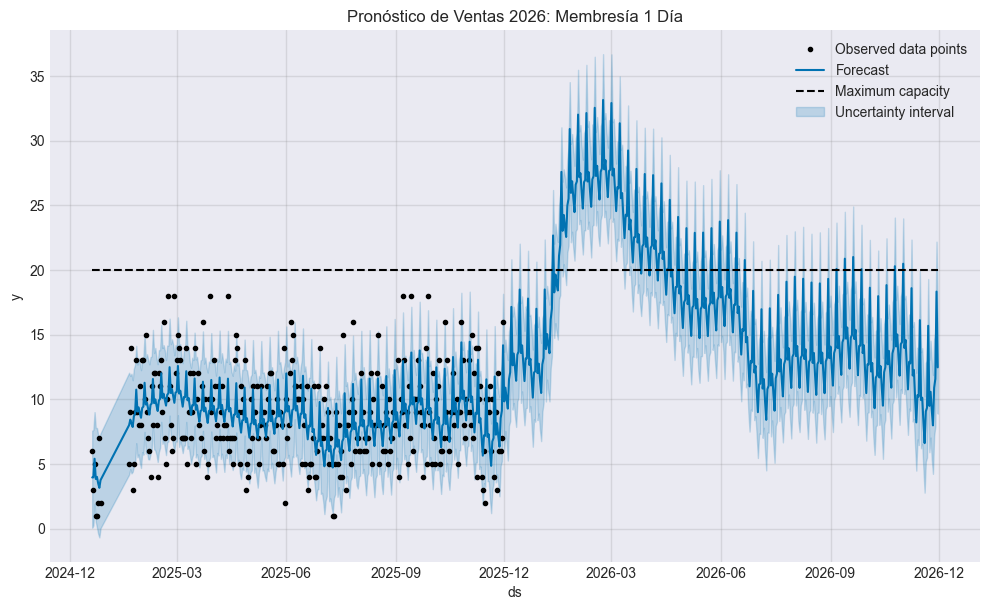

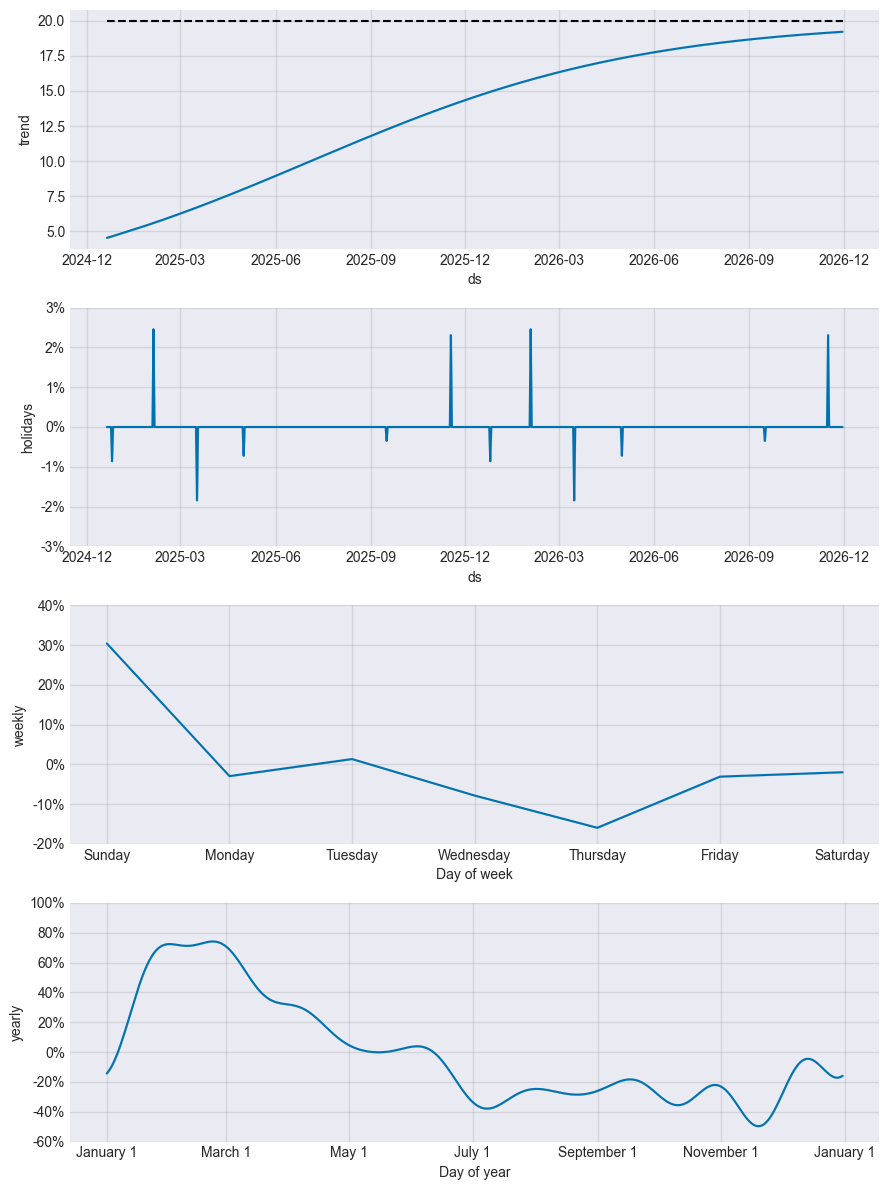

In [13]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas 2026: Membresía 1 Día")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [14]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(0).reset_index()
print(monthly_sales)

      month   yhat  yhat_lower  yhat_upper
0   2024-12   32.0         2.0        61.0
1   2025-01  106.0        61.0       151.0
2   2025-02  284.0       180.0       389.0
3   2025-03  305.0       189.0       419.0
4   2025-04  272.0       160.0       385.0
5   2025-05  264.0       149.0       380.0
6   2025-06  258.0       148.0       370.0
7   2025-07  215.0       100.0       333.0
8   2025-08  259.0       143.0       375.0
9   2025-09  287.0       174.0       399.0
10  2025-10  283.0       168.0       397.0
11  2025-11  258.0       146.0       370.0
12  2025-12  397.0       283.0       513.0
13  2026-01  644.0       529.0       759.0
14  2026-02  776.0       672.0       880.0
15  2026-03  762.0       646.0       878.0
16  2026-04  615.0       505.0       727.0
17  2026-05  556.0       441.0       672.0
18  2026-06  491.0       381.0       603.0
19  2026-07  378.0       261.0       494.0
20  2026-08  425.0       309.0       541.0
21  2026-09  440.0       328.0       551.0
22  2026-10

In [15]:
monthly_sales.to_csv(f"../data/data_forecast_{anio}/data_forecast_{anio}_gold/forecast_numero_{name_file}_{anio}_monthly.csv")

In [16]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.